# Benchmark Results
This notebook visualizes the output from the different models on different classification problems

In [1]:
import collections
import glob
import itertools
import json
import os

import numpy as np
import pandas as pd
import plotnine
from plotnine import *

from saged.utils import split_sample_names, create_dataset_stat_df, get_dataset_stats, parse_map_file

## Binary Prediction

In [46]:
top_five_tissues = ['Blood', 'Breast', 'Stem_Cell', 'Cervix', 'Brain']
#top_five_tissues = ['Blood', 'Breast', 'Stem_Cell']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Breast'), ('Blood', 'Stem_Cell'), ('Blood', 'Cervix')]

In [47]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

360

In [48]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[0]
    tissue2 = run_info[1]
    
    model_and_seed = run_info[2].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    
    new_df['supervised'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['supervised'] = run_results['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
run_results

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,supervised,seed,tissue1,tissue2,correction_method,pair,train_count
0,0.706667,0.568293,0.812249,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",301,0.1,"0,1,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,Blood-Breast,301
1,0.652549,0.530625,0.770109,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",602,0.2,"0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,Blood-Breast,602
2,0.690196,0.561015,0.798982,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",904,0.3,"0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,Blood-Breast,904
3,0.681569,0.586698,0.786316,"SRP002915,DRP001150,SRP031476,SRP006726,SRP011...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1205,0.4,"0,1,0,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,Blood-Breast,1205
4,0.666667,0.587404,0.771873,"SRP002915,DRP001150,SRP031476,SRP006726,SRP011...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1507,0.5,"0,1,0,1,1,0,1,0,0,0,1,0,1,1,1,1,0,0,1,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,Blood-Breast,1507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.769231,0.500000,0.000000,"SRP013825,DRP002721,SRP038987,SRP002640,SRP026...","SRR945228,SRR447184,SRR1004301,SRR921552,SRR06...","SRR309282,SRR309283,SRR309284,SRR309289,SRR036...",360,0.6,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...","{""Brain"": 0, ""Cervix"": 1}",pytorch_lr,0,Brain,Cervix,study_corrected,Brain-Cervix,360
46,0.747253,0.510714,0.115385,"SRP013825,DRP002721,SRP038987,SRP002640,SRP026...","SRR945228,SRR447184,SRR1004301,SRR921552,SRR06...","SRR309282,SRR309283,SRR309284,SRR309289,SRR036...",420,0.7,"0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...","1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...","{""Brain"": 0, ""Cervix"": 1}",pytorch_lr,0,Brain,Cervix,study_corrected,Brain-Cervix,420
47,0.571429,0.454762,0.204082,"SRP013825,DRP002721,SRP038987,SRP002640,SRP026...","SRR945228,SRR447184,SRR1004301,SRR921552,SRR06...","SRR309282,SRR309283,SRR309284,SRR309289,SRR036...",480,0.8,"0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,...","1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...","{""Brain"": 0, ""Cervix"": 1}",pytorch_lr,0,Brain,Cervix,study_corrected,Brain-Cervix,480
48,0.637363,0.497619,0.232558,"SRP007862,SRP013825,DRP002721,SRP038987,SRP002...","SRR945228,SRR447184,SRR1004301,SRR921552,SRR06...","SRR309282,SRR309283,SRR309284,SRR309289,SRR036...",540,0.9,"0,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,...","1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...","{""Brain"": 0, ""Cervix"": 1}",pytorch_lr,0,Brain,Cervix,study_corrected,Brain-Cervix,540


## Pairwise comparisons

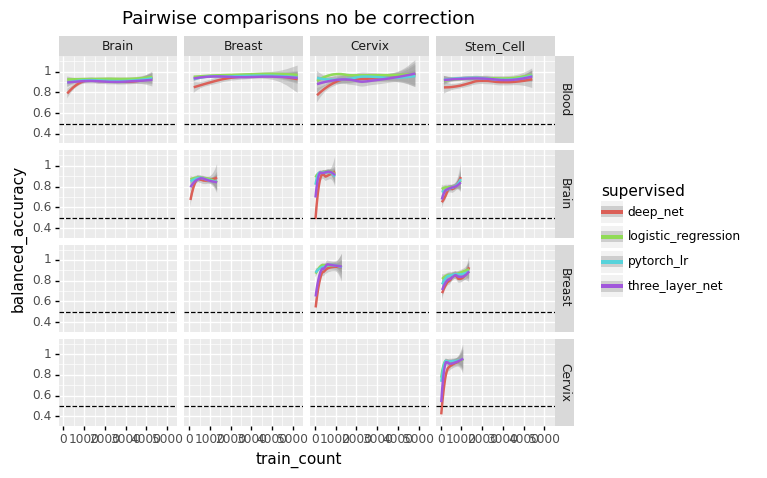

<ggplot: (8756460224729)>

In [52]:
plot_df = run_results[run_results['correction_method'] == 'unmodified']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
#plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'])
plot += ggtitle('Pairwise comparisons no be correction')
plot

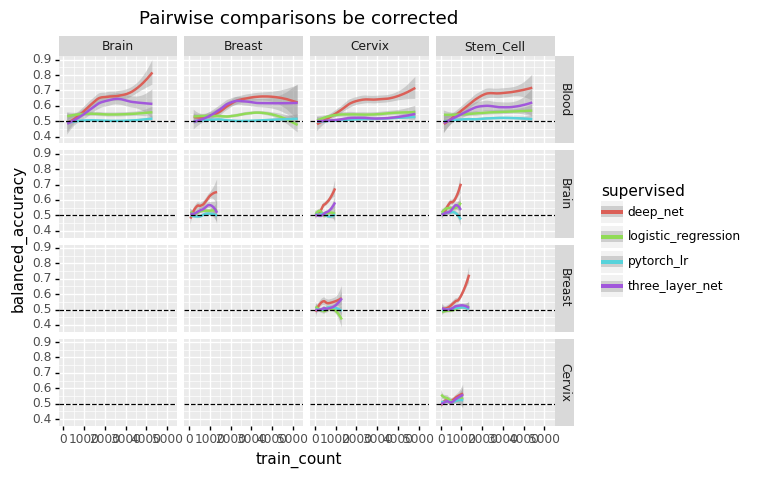

<ggplot: (8756416777673)>

In [53]:
plot_df = run_results[run_results['correction_method'] == 'study_corrected']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
#plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'])
plot += ggtitle('Pairwise comparisons be corrected')
plot

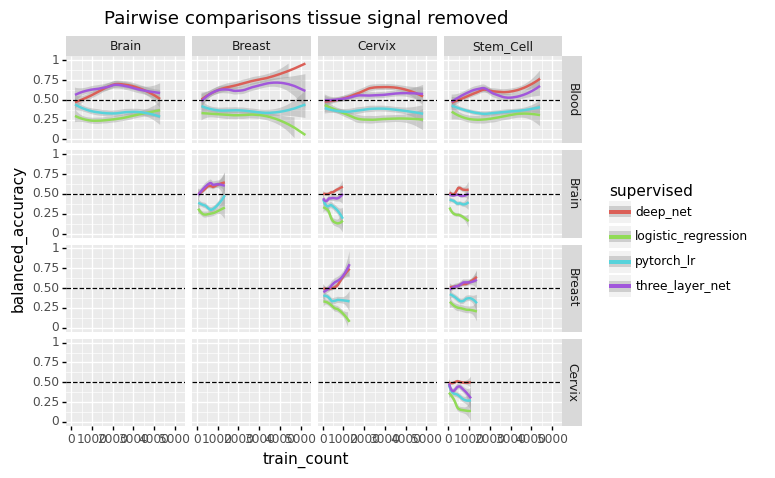

<ggplot: (8756415998349)>

In [54]:
plot_df = run_results[run_results['correction_method'] == 'signal_removed']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
#plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'])
plot += ggtitle('Pairwise comparisons tissue signal removed')
plot += ylim(0, 1)
plot

### Pairwise accuracy

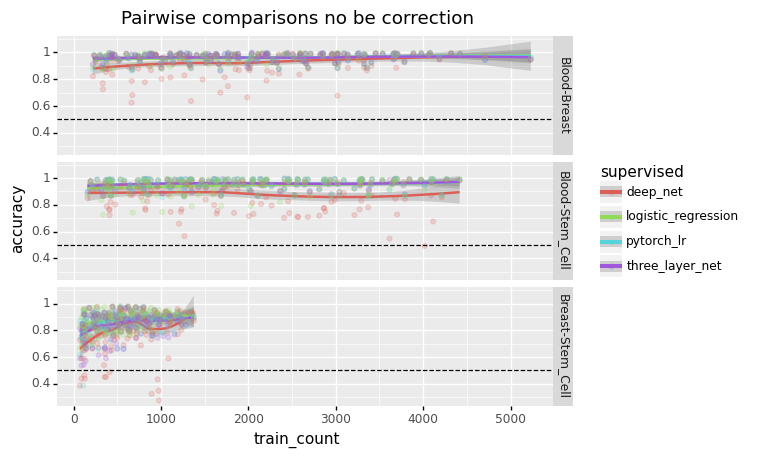

<ggplot: (8756416725405)>

In [11]:
plot_df = run_results[run_results['correction_method'] == 'unmodified']
plot = ggplot(plot_df, aes(x='train_count', y='accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid('pair ~ .')
plot += ggtitle('Pairwise comparisons no be correction')
plot

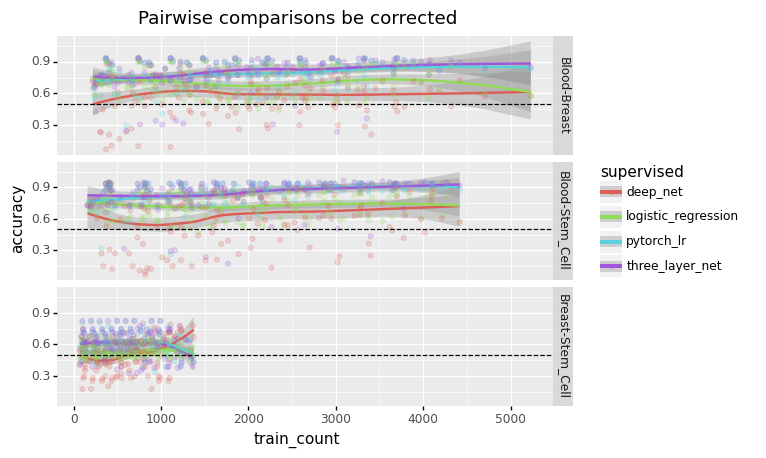

<ggplot: (8756459870637)>

In [12]:
plot_df = run_results[run_results['correction_method'] == 'study_corrected']
plot = ggplot(plot_df, aes(x='train_count', y='accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid('pair ~ .')
plot += ggtitle('Pairwise comparisons be corrected')
plot

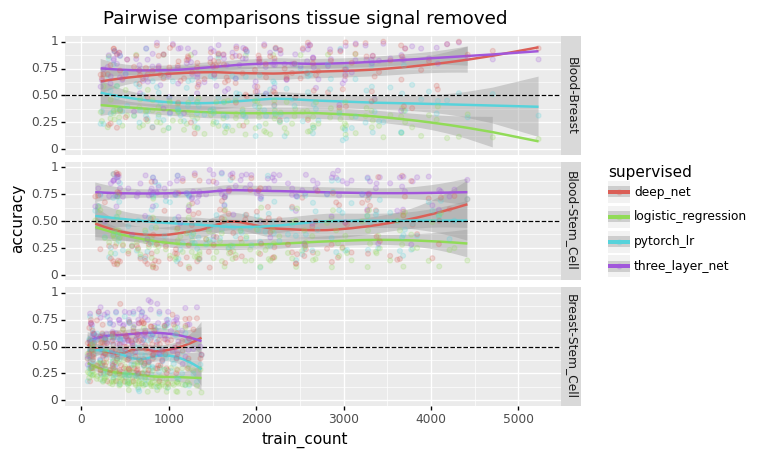

<ggplot: (8756416357733)>

In [13]:
plot_df = run_results[run_results['correction_method'] == 'signal_removed']
plot = ggplot(plot_df, aes(x='train_count', y='accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid('pair ~ .')
plot += ggtitle('Pairwise comparisons tissue signal removed')
plot += ylim(0, 1)
plot

## Tissue Prediction

In [14]:
in_files = glob.glob('../../results/Blood.Breast.*.tsv')
print(in_files[:5])

['../../results/Blood.Breast.logistic_regression_2-study_corrected.tsv', '../../results/Blood.Breast.deep_net_2-study_corrected.tsv', '../../results/Blood.Breast.pytorch_lr_2.tsv', '../../results/Blood.Breast.deep_net_2.tsv', '../../results/Blood.Breast.deep_net_1.tsv']


In [15]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[0]
    tissue2 = run_info[1]
    
    model_and_seed = run_info[2].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    
    new_df['supervised'] = model
    new_df['seed'] = seed
    new_df['tissue1'] = tissue1
    new_df['tissue2'] = tissue2
    new_df['correction_method'] = correction_method
    
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,supervised,seed,tissue1,tissue2,correction_method,train_count
0,0.706667,0.568293,0.812249,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",301,0.1,"0,1,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,301
1,0.652549,0.530625,0.770109,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",602,0.2,"0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,602
2,0.690196,0.561015,0.798982,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",904,0.3,"0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,904
3,0.681569,0.586698,0.786316,"SRP002915,DRP001150,SRP031476,SRP006726,SRP011...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1205,0.4,"0,1,0,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,1205
4,0.666667,0.587404,0.771873,"SRP002915,DRP001150,SRP031476,SRP006726,SRP011...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1507,0.5,"0,1,0,1,1,0,1,0,0,0,1,0,1,1,1,1,0,0,1,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,2,Blood,Breast,study_corrected,1507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.684531,0.586593,0.791297,"SRP029889,SRP028554,SRP057500,SRP042153,SRP004...","SRR805780,SRR1177678,SRR1270779,ERR356368,SRR1...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",2439,0.6,"1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,1,Blood,Breast,study_corrected,2439
46,0.667479,0.582432,0.776413,"SRP029889,SRP028554,SRP057500,SRP042153,SRP004...","SRR805780,SRR1177678,SRR1270779,ERR356368,SRR1...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",2846,0.7,"1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,1,Blood,Breast,study_corrected,2846
47,0.656516,0.571147,0.768092,"SRP029889,SRP028554,SRP057500,SRP042153,SRP004...","SRR805780,SRR1177678,SRR1270779,ERR356368,SRR1...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",3252,0.8,"1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,1,Blood,Breast,study_corrected,3252
48,0.590743,0.540694,0.708333,"SRP029889,SRP028554,SRP057500,SRP042153,SRP004...","SRR805780,SRR1177678,SRR1270779,ERR356368,SRR1...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",3659,0.9,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,1,Blood,Breast,study_corrected,3659


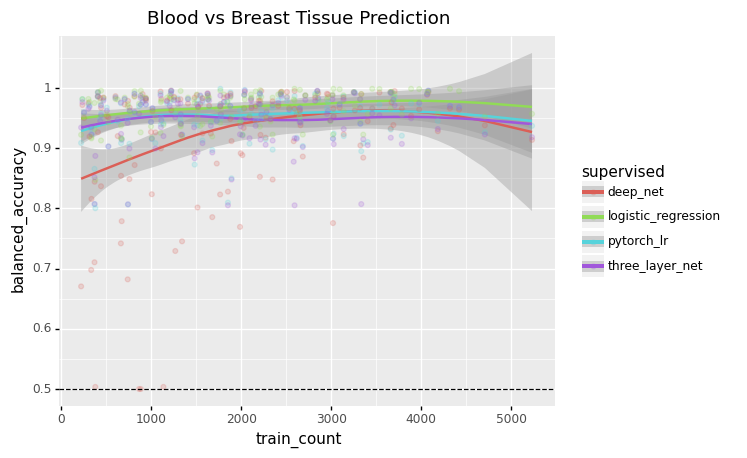

<ggplot: (8756416746357)>

In [16]:
plot_df = tissue_metrics[tissue_metrics['correction_method'] == 'unmodified']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Blood vs Breast Tissue Prediction')
plot

### BE Corrected binary tissue classification

In [17]:
in_files = glob.glob('../../results/Blood.Breast.*.tsv')
in_files = [f for f in in_files if 'study_corrected' in f]
print(in_files[:5])

['../../results/Blood.Breast.logistic_regression_2-study_corrected.tsv', '../../results/Blood.Breast.deep_net_2-study_corrected.tsv', '../../results/Blood.Breast.pytorch_lr_2-study_corrected.tsv', '../../results/Blood.Breast.deep_net_0-study_corrected.tsv', '../../results/Blood.Breast.pytorch_supervised_1-study_corrected.tsv']


In [18]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('Breast.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.706667,0.568293,0.812249,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",301,0.1,"0,1,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,301
1,0.652549,0.530625,0.770109,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",602,0.2,"0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,602
2,0.690196,0.561015,0.798982,"SRP002915,DRP001150,SRP031476,SRP011130,SRP044...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",904,0.3,"0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,904
3,0.681569,0.586698,0.786316,"SRP002915,DRP001150,SRP031476,SRP006726,SRP011...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1205,0.4,"0,1,0,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,1205
4,0.666667,0.587404,0.771873,"SRP002915,DRP001150,SRP031476,SRP006726,SRP011...","ERR204907,SRR2052744,SRR2049722,SRR1027172,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1507,0.5,"0,1,0,1,1,0,1,0,0,0,1,0,1,1,1,1,0,0,1,1,0,1,1,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,1507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.684531,0.586593,0.791297,"SRP029889,SRP028554,SRP057500,SRP042153,SRP004...","SRR805780,SRR1177678,SRR1270779,ERR356368,SRR1...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",2439,0.6,"1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,2439
46,0.667479,0.582432,0.776413,"SRP029889,SRP028554,SRP057500,SRP042153,SRP004...","SRR805780,SRR1177678,SRR1270779,ERR356368,SRR1...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",2846,0.7,"1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,2846
47,0.656516,0.571147,0.768092,"SRP029889,SRP028554,SRP057500,SRP042153,SRP004...","SRR805780,SRR1177678,SRR1270779,ERR356368,SRR1...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",3252,0.8,"1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,3252
48,0.590743,0.540694,0.708333,"SRP029889,SRP028554,SRP057500,SRP042153,SRP004...","SRR805780,SRR1177678,SRR1270779,ERR356368,SRR1...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",3659,0.9,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,3659


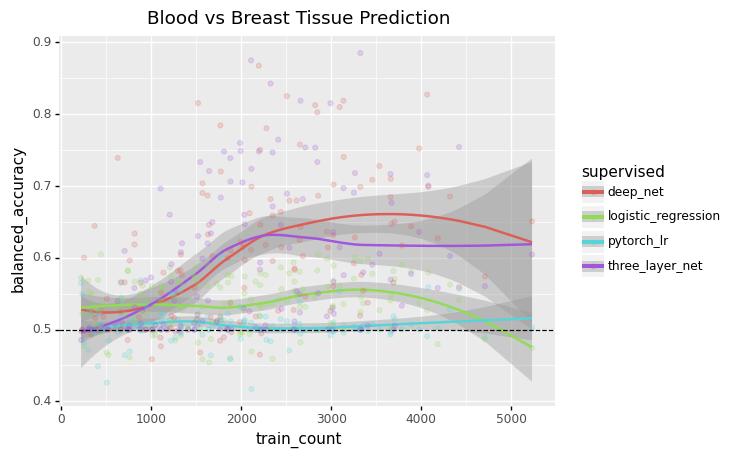

<ggplot: (8756415929609)>

In [19]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Blood vs Breast Tissue Prediction')
plot

### All Tissue Predictions

In [20]:
in_files = glob.glob('../../results/all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/all-tissue.pytorch_lr_2.tsv', '../../results/all-tissue.deep_net_1.tsv', '../../results/all-tissue.logistic_regression_2.tsv', '../../results/all-tissue.pytorch_supervised_1.tsv', '../../results/all-tissue.pytorch_supervised_2.tsv']


In [21]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('deep_net', 'five_layer_net')
tissue_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,supervised,seed,train_count
0,0.447565,0.397952,NaN,"SRP062966,SRP022913,SRP022166,SRP042623,SRP040...","SRR988502,SRR1608734,ERR752667,ERR188211,SRR19...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",963,0.1,pytorch_lr,2,963
1,0.485301,0.353683,NaN,"SRP022913,SRP059039,SRP015336,SRP032363,SRP011...","SRR988502,SRR1608734,ERR752667,ERR188211,SRR19...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1927,0.2,pytorch_lr,2,1927
2,0.376042,0.263833,NaN,"SRP022913,SRP059039,SRP015336,SRP032363,SRP017...","SRR988502,SRR1608734,ERR752667,ERR188211,SRR19...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",2891,0.3,pytorch_lr,2,2891
3,0.560772,0.430076,NaN,"SRP022913,SRP059039,SRP015336,SRP032363,SRP017...","SRR988502,SRR1608734,ERR752667,ERR188211,SRR19...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",3855,0.4,pytorch_lr,2,3855
4,0.691093,0.498175,NaN,"SRP022913,SRP059039,SRP015336,SRP032363,SRP017...","SRR988502,SRR1608734,ERR752667,ERR188211,SRR19...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",4819,0.5,pytorch_lr,2,4819
...,...,...,...,...,...,...,...,...,...,...,...
45,0.715869,0.547028,NaN,"SRP043043,SRP029889,SRP059039,SRP042184,SRP019...","SRR1608866,SRR1982777,SRR1313107,SRR1268167,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",5634,0.6,logistic_regression,1,5634
46,0.696874,0.547070,NaN,"SRP043043,SRP029889,SRP059039,SRP042184,SRP019...","SRR1608866,SRR1982777,SRR1313107,SRR1268167,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",6573,0.7,logistic_regression,1,6573
47,0.703601,0.541714,NaN,"SRP043043,SRP029889,SRP059039,SRP042184,SRP019...","SRR1608866,SRR1982777,SRR1313107,SRR1268167,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",7512,0.8,logistic_regression,1,7512
48,0.665611,0.538316,NaN,"SRP043043,SRP029889,SRP059039,SRP042184,SRP019...","SRR1608866,SRR1982777,SRR1313107,SRR1268167,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",8451,0.9,logistic_regression,1,8451


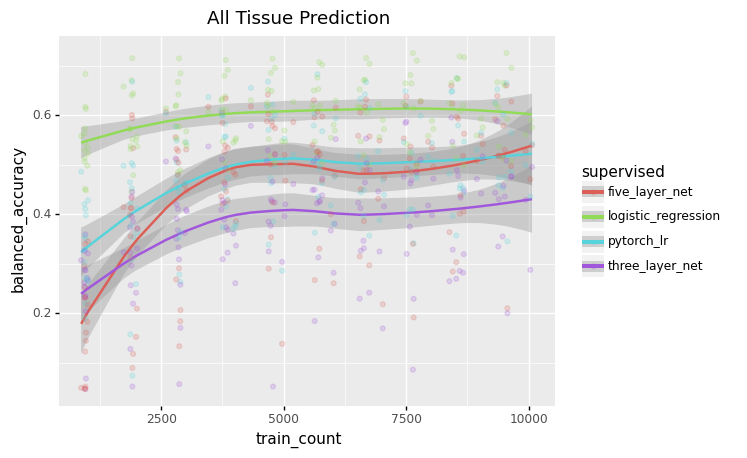

<ggplot: (8756415787245)>

In [22]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('All Tissue Prediction')
plot

## Imputation pretraining

In [20]:
in_files = glob.glob('../../results/tissue_impute.*.tsv')
print(in_files[:5])

['../../results/tissue_impute.five_layer_impute_1.tsv', '../../results/tissue_impute.five_layer_impute_2.tsv', '../../results/tissue_impute.three_layer_impute_1.tsv', '../../results/tissue_impute.three_layer_impute_0.tsv', '../../results/tissue_impute.three_layer_impute_2.tsv']


In [21]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tissue_impute.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics = tissue_metrics.rename({'impute_samples': 'pretraining_sample_count'}, axis='columns')
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,pretraining_sample_count,supervised,seed,train_count
0,0.327108,0.063728,"SRP005281,SRP012656,SRP031858,SRP009790,SRP017...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",993,0.1,0,five_layer,1,993
1,0.377082,0.145956,"SRP005281,SRP012656,SRP031858,SRP009790,SRP017...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",993,0.1,17320,five_layer,1,993
2,0.356890,0.124458,"SRP021214,SRP026042,SRP015640,SRP032743,SRP023...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",1987,0.2,0,five_layer,1,1987
3,0.379101,0.139422,"SRP021214,SRP026042,SRP015640,SRP032743,SRP023...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",1987,0.2,17320,five_layer,1,1987
4,0.570924,0.216153,"SRP021214,SRP026042,SRP015640,SRP032743,SRP023...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",2981,0.3,0,five_layer,1,2981
...,...,...,...,...,...,...,...,...,...,...,...
95,0.605626,0.409489,"SRP027358,SRP001462,SRP041159,SRP041255,SRP035...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",8027,0.8,17320,five_layer,0,8027
96,0.494692,0.324735,"SRP027358,SRP001462,SRP041159,SRP041255,SRP035...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",9030,0.9,0,five_layer,0,9030
97,0.609873,0.388163,"SRP027358,SRP001462,SRP041159,SRP041255,SRP035...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",9030,0.9,17320,five_layer,0,9030
98,0.341295,0.121709,"SRP027358,SRP001462,SRP041159,SRP041255,SRP035...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",10034,1.0,0,five_layer,0,10034


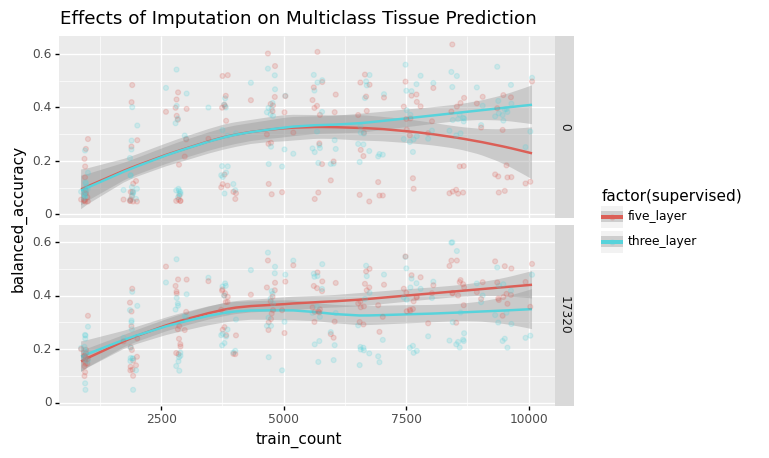

<ggplot: (8759142506249)>

In [22]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='factor(supervised)')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Effects of Imputation on Multiclass Tissue Prediction')
plot += facet_grid('pretraining_sample_count ~ .')
plot

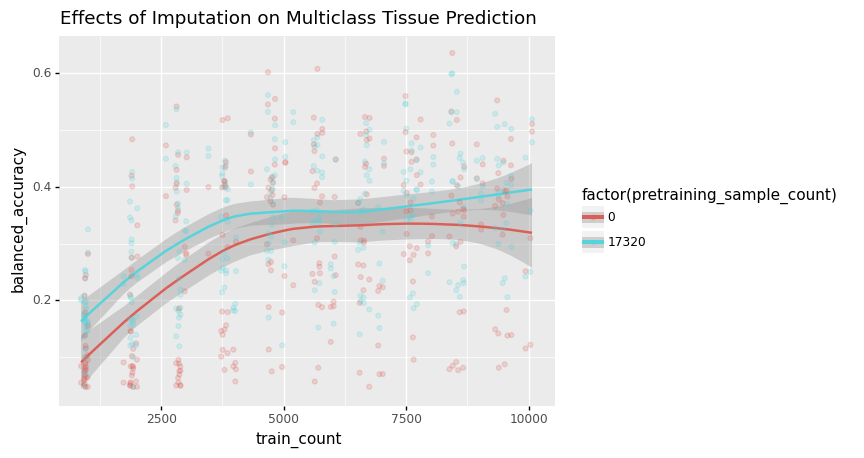

<ggplot: (8759142999205)>

In [23]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='factor(pretraining_sample_count)')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Effects of Imputation on Multiclass Tissue Prediction')
plot

## Adding BioBERT Embeddings

In [24]:
in_files = glob.glob('../../results/all-tissue-biobert*.tsv')
print(in_files[:5])

['../../results/all-tissue-biobert.logistic_regression_0.tsv', '../../results/all-tissue-biobert.pytorch_lr_2.tsv', '../../results/all-tissue-biobert.logistic_regression_1.tsv', '../../results/all-tissue-biobert.pytorch_supervised_2.tsv', '../../results/all-tissue-biobert.pytorch_supervised_1.tsv']


In [25]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics = tissue_metrics.rename({'impute_samples': 'pretraining_sample_count'}, axis='columns')
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,supervised,seed,train_count
0,0.501368,0.492308,NaN,"SRP028170,SRP002487,SRP057500,SRP041396,SRP015...","SRR1398540,ERR188217,SRR189778,SRR1274529,SRR1...","SRR333479,SRR960409,SRR960410,SRR960411,SRR960...",935,0.1,logistic_regression,0,935
1,0.495897,0.530440,NaN,"SRP028170,SRP023270,SRP002487,SRP057500,SRP019...","SRR1398540,ERR188217,SRR189778,SRR1274529,SRR1...","SRR333479,SRR960409,SRR960410,SRR960411,SRR960...",1871,0.2,logistic_regression,0,1871
2,0.580305,0.558963,NaN,"SRP028170,SRP023270,SRP002487,SRP057500,SRP019...","SRR1398540,ERR188217,SRR189778,SRR1274529,SRR1...","SRR333479,SRR960409,SRR960410,SRR960411,SRR960...",2807,0.3,logistic_regression,0,2807
3,0.518562,0.550209,NaN,"SRP028170,SRP023270,SRP002487,SRP057500,SRP019...","SRR1398540,ERR188217,SRR189778,SRR1274529,SRR1...","SRR333479,SRR960409,SRR960410,SRR960411,SRR960...",3743,0.4,logistic_regression,0,3743
4,0.584603,0.591930,NaN,"SRP028170,SRP023270,SRP002487,SRP057500,SRP019...","SRR1398540,ERR188217,SRR189778,SRR1274529,SRR1...","SRR333479,SRR960409,SRR960410,SRR960411,SRR960...",4679,0.5,logistic_regression,0,4679
...,...,...,...,...,...,...,...,...,...,...,...
45,0.368896,0.339093,NaN,"SRP019936,SRP014620,SRP002128,SRP000996,SRP026...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",6020,0.6,deep_net,0,6020
46,0.214437,0.207144,NaN,"SRP019936,SRP014620,SRP002128,SRP000996,SRP026...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",7023,0.7,deep_net,0,7023
47,0.612527,0.536949,NaN,"SRP019936,SRP014620,SRP002128,SRP019946,SRP000...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",8027,0.8,deep_net,0,8027
48,0.605096,0.540375,NaN,"SRP019936,SRP014620,SRP002128,SRP019946,SRP000...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",9030,0.9,deep_net,0,9030


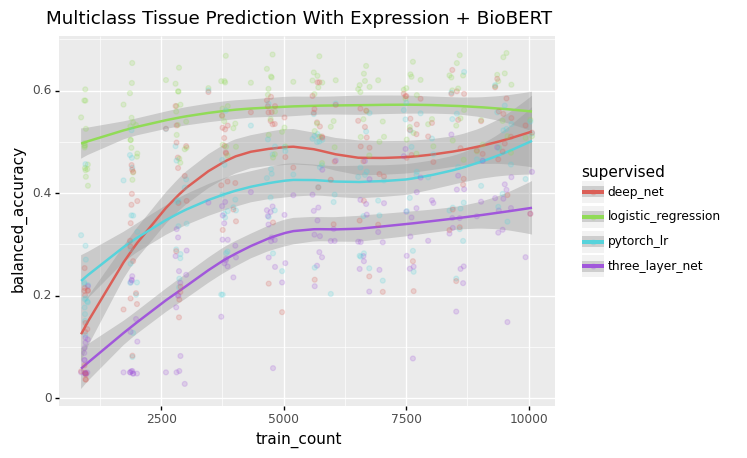

<ggplot: (8759142423389)>

In [26]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Multiclass Tissue Prediction With Expression + BioBERT')
plot

## Sample Split Positive Control

In [27]:
in_files = glob.glob('../../results/sample-split.*.tsv')
print(in_files[:5])

['../../results/sample-split.deep_net_2.tsv', '../../results/sample-split.pytorch_lr_0.tsv', '../../results/sample-split.pytorch_lr_2.tsv', '../../results/sample-split.deep_net_1.tsv', '../../results/sample-split.pytorch_supervised_0.tsv']


In [28]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.739933,0.699252,"SRP041255,SRP021916,SRP041751,SRP022133,SRP044...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,pretrained,"0,0,0,2,9,5,16,6,16,13,12,0,0,14,9,0,0,0,10,15...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
1,0.123742,0.167131,"SRP041255,SRP021916,SRP041751,SRP022133,SRP044...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,not_pretrained,"18,13,19,13,18,13,16,13,13,13,13,18,2,14,14,10...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
2,0.862836,0.807580,"SRP041255,SRP021916,SRP041751,SRP022133,SRP044...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,pretrained,"0,0,0,0,9,5,17,6,11,14,12,0,16,14,9,0,0,0,10,1...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
3,0.064178,0.087515,"SRP041255,SRP021916,SRP041751,SRP022133,SRP044...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,not_pretrained,"18,18,19,19,16,16,19,19,16,19,19,18,16,16,19,2...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
4,0.864094,0.738800,"SRP041255,SRP041751,SRP044668,SRP011130,SRP050...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",1429,0.3,pretrained,"0,0,0,0,9,5,17,6,17,14,12,0,16,14,9,0,0,0,10,1...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,1429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.691565,0.366099,"SRP021524,SRP006474,SRP019936,SRP026044,SRP034...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",3813,0.8,not_pretrained,"0,12,0,11,17,0,3,0,4,4,3,0,12,11,11,0,3,17,11,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,3813
96,0.849350,0.702431,"SRP021524,SRP006474,SRP019936,SRP026044,SRP034...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,pretrained,"0,12,0,11,17,0,17,0,14,7,3,0,12,4,20,16,3,4,4,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
97,0.771297,0.625953,"SRP021524,SRP006474,SRP019936,SRP026044,SRP034...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,not_pretrained,"0,12,0,11,17,0,3,0,4,7,3,0,12,4,4,16,3,4,4,19,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
98,0.850608,0.691270,"SRP021524,SRP006474,SRP019936,SRP026044,SRP034...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4767,1.0,pretrained,"0,12,0,11,17,0,4,0,14,11,3,0,12,4,20,16,3,4,4,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4767


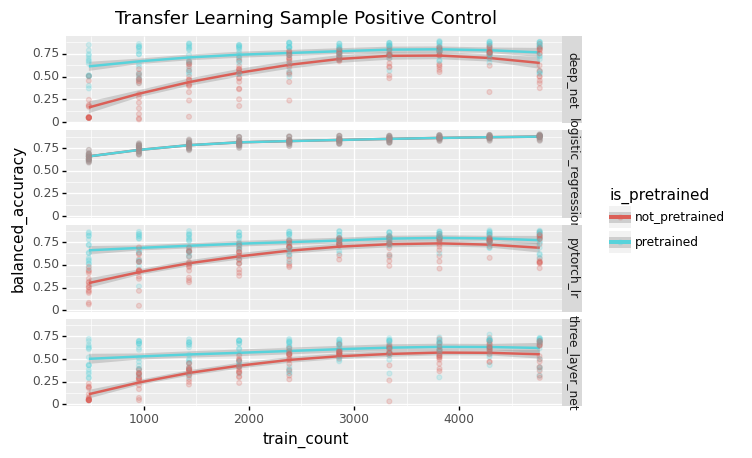

<ggplot: (8759142218381)>

In [29]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Transfer Learning Sample Positive Control')
plot += facet_grid('supervised ~ .')
plot

In [30]:
single_run_df = tissue_metrics[tissue_metrics['seed'] == '1']
single_run_df.head()

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.318792,0.397974,"SRP016568,SRP035988,SRP018716,SRP015668,SRP044...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",476,0.1,pretrained,"17,6,8,3,17,19,19,19,19,19,5,19,19,0,5,2,12,19...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,476
1,0.012584,0.044643,"SRP016568,SRP035988,SRP018716,SRP015668,SRP044...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",476,0.1,not_pretrained,"16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,1...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,476
2,0.513003,0.538237,"SRP016568,SRP035988,SRP018716,SRP015668,SRP044...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",953,0.2,pretrained,"17,3,8,17,2,14,20,0,0,0,14,19,0,0,16,2,7,0,14,...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,953
3,0.412752,0.473722,"SRP016568,SRP035988,SRP018716,SRP015668,SRP044...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",953,0.2,not_pretrained,"17,3,8,3,15,14,20,0,0,0,14,0,19,2,16,2,9,19,14...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,953
4,0.470218,0.544888,"SRP018716,SRP015668,ERP009437,SRP030475,SRP019...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",1429,0.3,pretrained,"17,6,8,3,15,14,20,0,0,0,14,19,0,19,5,16,9,0,3,...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,1429


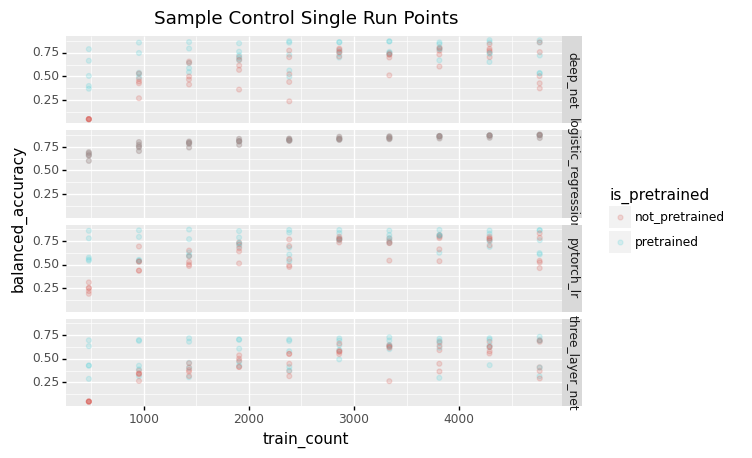

<ggplot: (8759141983485)>

In [31]:
plot = ggplot(single_run_df, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
#plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sample Control Single Run Points')
plot += facet_grid('supervised ~ .')
plot

## Study Split Positive Control

In [32]:
in_files = glob.glob('../../results/study-split.*.tsv')
print(in_files[:5])

['../../results/study-split.pytorch_supervised_2.tsv', '../../results/study-split.deep_net_2.tsv', '../../results/study-split.logistic_regression_2.tsv', '../../results/study-split.pytorch_lr_2.tsv', '../../results/study-split.logistic_regression_1.tsv']


In [33]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.550241,0.307520,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",478,0.1,pretrained,"11,11,11,11,11,11,5,4,4,4,6,6,6,6,6,3,3,3,3,3,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,478
1,0.336551,0.096469,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",478,0.1,not_pretrained,"0,0,0,0,0,0,5,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,478
2,0.593243,0.324776,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",957,0.2,pretrained,"11,11,11,5,5,5,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,957
3,0.424748,0.058479,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",957,0.2,not_pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,957
4,0.635805,0.336969,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1435,0.3,pretrained,"11,11,11,11,11,11,5,4,4,4,11,11,11,11,11,3,3,3...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,1435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.643312,0.530296,"SRP007461,SRP043368,SRP038702,SRP015964,SRP008...","SRR037223,SRR1200511,SRR957903,SRR1182358,SRR2...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",3375,0.8,not_pretrained,"4,4,4,11,11,11,11,11,3,3,3,3,3,3,3,3,3,8,8,8,8...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,0,3375
96,0.651274,0.527851,"SRP007461,SRP043368,SRP038702,SRP015964,SRP008...","SRR037223,SRR1200511,SRR957903,SRR1182358,SRR2...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",3797,0.9,pretrained,"4,4,4,11,11,11,11,11,3,3,3,3,3,3,3,3,3,8,8,8,8...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,0,3797
97,0.651274,0.527851,"SRP007461,SRP043368,SRP038702,SRP015964,SRP008...","SRR037223,SRR1200511,SRR957903,SRR1182358,SRR2...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",3797,0.9,not_pretrained,"4,4,4,11,11,11,11,11,3,3,3,3,3,3,3,3,3,8,8,8,8...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,0,3797
98,0.633758,0.550480,"SRP007461,SRP043368,SRP038702,SRP015964,SRP008...","SRR037223,SRR1200511,SRR957903,SRR1182358,SRR2...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",4219,1.0,pretrained,"4,4,4,11,11,11,11,11,3,3,3,3,3,3,3,3,3,8,8,8,8...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,0,4219


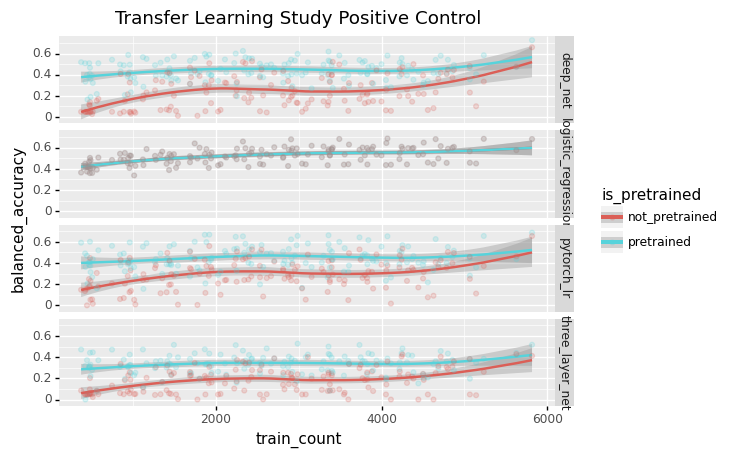

<ggplot: (8759142213805)>

In [34]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Transfer Learning Study Positive Control')
plot += facet_grid('supervised ~ .')
plot

In [35]:
single_run_df = tissue_metrics[tissue_metrics['seed'] == '1']
single_run_df.head()

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.567390,0.361583,"SRP011107,SRP011924,SRP026044,SRP016629,SRP030...","SRR1193564,ERR188065,SRR393765,ERR204930,SRR11...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",506,0.1,pretrained,"9,9,9,9,20,5,5,5,5,20,20,20,5,20,19,19,19,19,1...","9,9,9,9,5,5,5,5,5,5,5,5,5,5,2,2,2,2,2,2,2,2,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,1,506
1,0.567390,0.361583,"SRP011107,SRP011924,SRP026044,SRP016629,SRP030...","SRR1193564,ERR188065,SRR393765,ERR204930,SRR11...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",506,0.1,not_pretrained,"9,9,9,9,20,5,5,5,5,20,20,20,5,20,19,19,19,19,1...","9,9,9,9,5,5,5,5,5,5,5,5,5,5,2,2,2,2,2,2,2,2,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,1,506
2,0.568400,0.338166,"SRP011107,SRP011924,SRP028822,SRP026044,SRP017...","SRR1193564,ERR188065,SRR393765,ERR204930,SRR11...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",1013,0.2,pretrained,"14,14,9,9,5,5,5,5,5,5,5,5,5,5,19,0,19,0,0,0,0,...","9,9,9,9,5,5,5,5,5,5,5,5,5,5,2,2,2,2,2,2,2,2,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,1,1013
3,0.568400,0.338166,"SRP011107,SRP011924,SRP028822,SRP026044,SRP017...","SRR1193564,ERR188065,SRR393765,ERR204930,SRR11...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",1013,0.2,not_pretrained,"14,14,9,9,5,5,5,5,5,5,5,5,5,5,19,0,19,0,0,0,0,...","9,9,9,9,5,5,5,5,5,5,5,5,5,5,2,2,2,2,2,2,2,2,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,1,1013
4,0.552751,0.410325,"SRP011107,SRP011924,SRP028822,SRP026044,SRP017...","SRR1193564,ERR188065,SRR393765,ERR204930,SRR11...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",1519,0.3,pretrained,"14,14,9,9,5,5,5,5,5,5,5,5,5,5,19,0,0,0,0,0,0,1...","9,9,9,9,5,5,5,5,5,5,5,5,5,5,2,2,2,2,2,2,2,2,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,1,1519


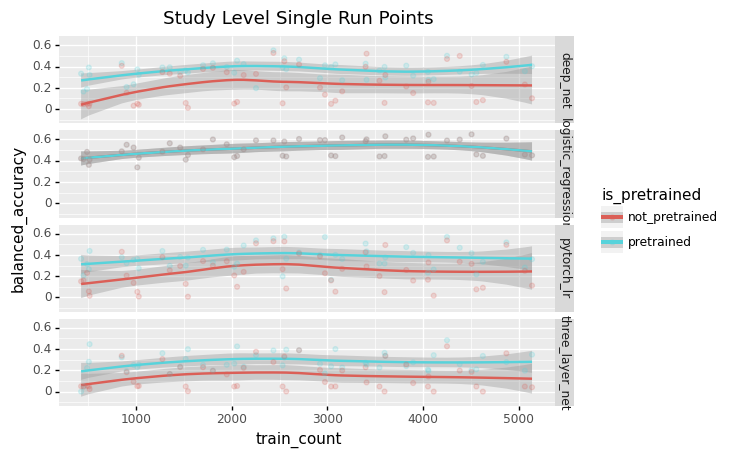

<ggplot: (8759142373565)>

In [36]:
plot = ggplot(single_run_df, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Study Level Single Run Points')
plot += facet_grid('supervised ~ .')
plot

## Sex Prediction

### Sample Level

In [23]:
in_files = glob.glob('../../results/sample-split-sex-prediction.*.tsv')
print(in_files[:5])

['../../results/sample-split-sex-prediction.pytorch_supervised_0.tsv', '../../results/sample-split-sex-prediction.logistic_regression_2.tsv', '../../results/sample-split-sex-prediction.pytorch_lr_0.tsv', '../../results/sample-split-sex-prediction.deep_net_0.tsv', '../../results/sample-split-sex-prediction.pytorch_supervised_2.tsv']


In [24]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.859724,0.860049,"SRP154388,SRP151496,SRP149978,SRP172519,SRP120...","SRR3304647,SRR957927,SRR3714643,SRR1585531,SRR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",941,0.1,pretrained,"0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,941
1,0.586185,0.587240,"SRP154388,SRP151496,SRP149978,SRP172519,SRP120...","SRR3304647,SRR957927,SRR3714643,SRR1585531,SRR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",941,0.1,not_pretrained,"0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,1,1,1,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,941
2,0.875452,0.875325,"SRP154388,SRP151496,SRP149978,SRP172519,SRP120...","SRR3304647,SRR957927,SRR3714643,SRR1585531,SRR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",1882,0.2,pretrained,"0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,1882
3,0.721785,0.721866,"SRP154388,SRP151496,SRP149978,SRP172519,SRP120...","SRR3304647,SRR957927,SRR3714643,SRR1585531,SRR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",1882,0.2,not_pretrained,"0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,0,0,1,0,1,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,1882
4,0.897131,0.896996,"SRP154388,SRP151496,SRP149978,SRP172519,SRP120...","SRR3304647,SRR957927,SRR3714643,SRR1585531,SRR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",2823,0.3,pretrained,"0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,2823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.906270,0.906245,"SRP113004,SRP028336,SRP133095,SRP056665,SRP049...","SRR3304789,SRR957954,SRR3714765,SRR1609565,SRR...","SRR7155727,SRR8080221,ERR2271020,SRR8908377,SR...",7528,0.8,not_pretrained,"1,0,1,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","{""female"": 0, ""male"": 1}",logistic_regression,0,7528
96,0.910946,0.910922,"SRP113004,SRP028336,SRP133095,SRP056665,SRP049...","SRR3304789,SRR957954,SRR3714765,SRR1609565,SRR...","SRR7155727,SRR8080221,ERR2271020,SRR8908377,SR...",8469,0.9,pretrained,"1,0,1,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","{""female"": 0, ""male"": 1}",logistic_regression,0,8469
97,0.910946,0.910922,"SRP113004,SRP028336,SRP133095,SRP056665,SRP049...","SRR3304789,SRR957954,SRR3714765,SRR1609565,SRR...","SRR7155727,SRR8080221,ERR2271020,SRR8908377,SR...",8469,0.9,not_pretrained,"1,0,1,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","{""female"": 0, ""male"": 1}",logistic_regression,0,8469
98,0.916047,0.916024,"SRP113004,SRP028336,SRP133095,SRP056665,SRP049...","SRR3304789,SRR957954,SRR3714765,SRR1609565,SRR...","SRR7155727,SRR8080221,ERR2271020,SRR8908377,SR...",9410,1.0,pretrained,"1,0,1,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","{""female"": 0, ""male"": 1}",logistic_regression,0,9410


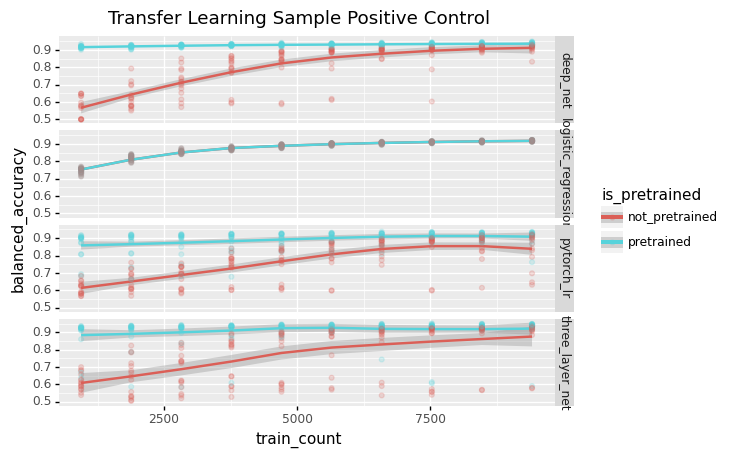

<ggplot: (8756415787065)>

In [25]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Transfer Learning Sample Positive Control')
plot += facet_grid('supervised ~ .')
plot

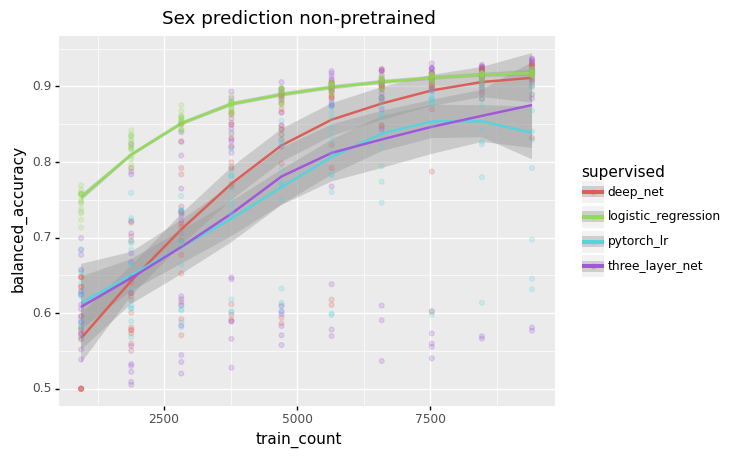

<ggplot: (8756416629565)>

In [27]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='supervised'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sex prediction non-pretrained')
plot

In [40]:
single_run_df = tissue_metrics[tissue_metrics['seed'] == '1']
single_run_df.head()

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.693943,0.692248,"SRP122528,SRP060362,SRP119917,SRP045823,SRP071...","SRR2546446,SRR7195874,SRR5981332,SRR6333696,SR...","SRR1643197,SRR7367643,ERR2983377,SRR3235872,SR...",941,0.1,pretrained,"1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,1,...","1,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,941
1,0.629756,0.625015,"SRP122528,SRP060362,SRP119917,SRP045823,SRP071...","SRR2546446,SRR7195874,SRR5981332,SRR6333696,SR...","SRR1643197,SRR7367643,ERR2983377,SRR3235872,SR...",941,0.1,not_pretrained,"0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,...","1,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,941
2,0.733475,0.732333,"SRP122528,SRP060362,SRP119917,SRP045823,SRP028...","SRR2546446,SRR7195874,SRR5981332,SRR6333696,SR...","SRR1643197,SRR7367643,ERR2983377,SRR3235872,SR...",1882,0.2,pretrained,"1,0,1,0,1,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,...","1,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,1882
3,0.721998,0.722007,"SRP122528,SRP060362,SRP119917,SRP045823,SRP028...","SRR2546446,SRR7195874,SRR5981332,SRR6333696,SR...","SRR1643197,SRR7367643,ERR2983377,SRR3235872,SR...",1882,0.2,not_pretrained,"1,0,1,0,1,1,0,1,0,0,1,0,1,1,1,0,1,0,1,0,0,1,0,...","1,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,1882
4,0.682253,0.680911,"SRP122528,SRP060362,SRP119917,SRP045823,SRP028...","SRR2546446,SRR7195874,SRR5981332,SRR6333696,SR...","SRR1643197,SRR7367643,ERR2983377,SRR3235872,SR...",2823,0.3,pretrained,"0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,1,...","1,1,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,2823


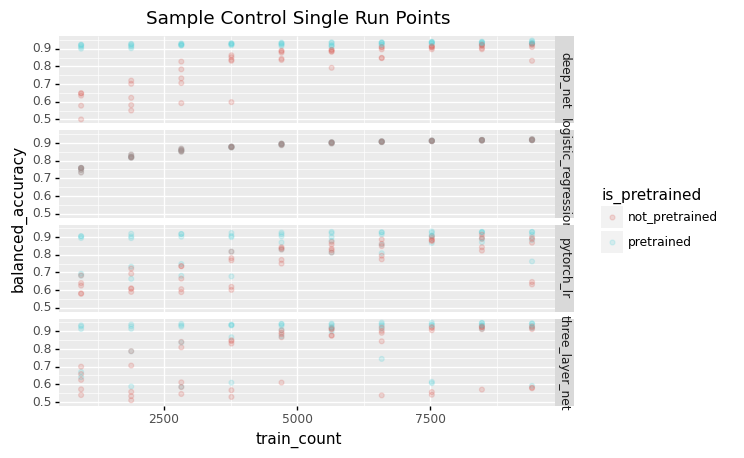

<ggplot: (8759185940909)>

In [41]:
plot = ggplot(single_run_df, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
#plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sample Control Single Run Points')
plot += facet_grid('supervised ~ .')
plot

### Study Level

In [42]:
in_files = glob.glob('../../results/study-split-sex-prediction.*.tsv')
print(in_files[:5])

['../../results/study-split-sex-prediction.pytorch_lr_1.tsv', '../../results/study-split-sex-prediction.pytorch_supervised_1.tsv', '../../results/study-split-sex-prediction.logistic_regression_1.tsv', '../../results/study-split-sex-prediction.pytorch_supervised_0.tsv', '../../results/study-split-sex-prediction.pytorch_lr_2.tsv']


In [43]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.683398,0.701480,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",838,0.1,pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,838
1,0.460299,0.506153,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",838,0.1,not_pretrained,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,838
2,0.747020,0.752782,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",1677,0.2,pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,1677
3,0.591573,0.608304,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",1677,0.2,not_pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,1677
4,0.703206,0.715549,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",2516,0.3,pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,2516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.656839,0.653334,"SRP063477,ERP010930,SRP078574,SRP198593,SRP117...","SRR7276198,SRR6940409,SRR7367996,SRR5826348,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",7727,0.8,not_pretrained,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,7727
96,0.790336,0.795057,"SRP063477,ERP010930,SRP078574,SRP198593,SRP117...","SRR7276198,SRR6940409,SRR7367996,SRR5826348,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",8693,0.9,pretrained,"1,1,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,8693
97,0.844390,0.840027,"SRP063477,ERP010930,SRP078574,SRP198593,SRP117...","SRR7276198,SRR6940409,SRR7367996,SRR5826348,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",8693,0.9,not_pretrained,"1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,8693
98,0.837019,0.835510,"SRP063477,ERP010930,SRP078574,SRP108920,SRP198...","SRR7276198,SRR6940409,SRR7367996,SRR5826348,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",9659,1.0,pretrained,"1,1,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,9659


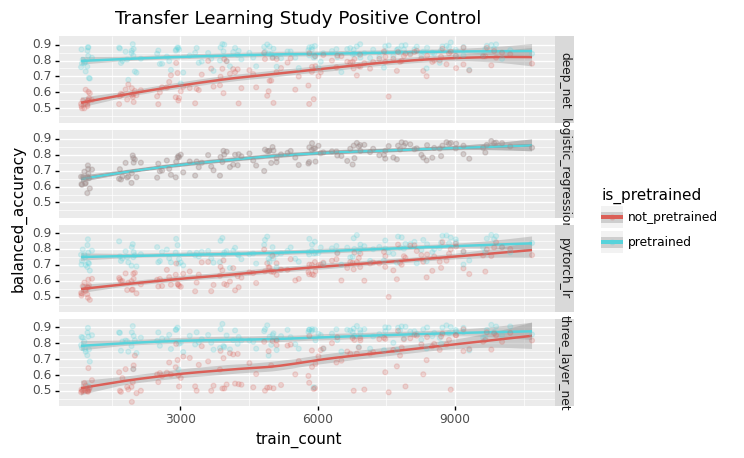

<ggplot: (8759143023961)>

In [44]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Transfer Learning Study Positive Control')
plot += facet_grid('supervised ~ .')
plot

In [45]:
single_run_df = tissue_metrics[tissue_metrics['seed'] == '1']
single_run_df.head()

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.683398,0.701480,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",838,0.1,pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,838
1,0.460299,0.506153,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",838,0.1,not_pretrained,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,838
2,0.747020,0.752782,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",1677,0.2,pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,1677
3,0.591573,0.608304,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",1677,0.2,not_pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,1677
4,0.703206,0.715549,"SRP183186,SRP128579,SRP049453,SRP032812,SRP075...","SRR3236098,SRR1643206,SRR2032106,SRR1798162,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",2516,0.3,pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,2516


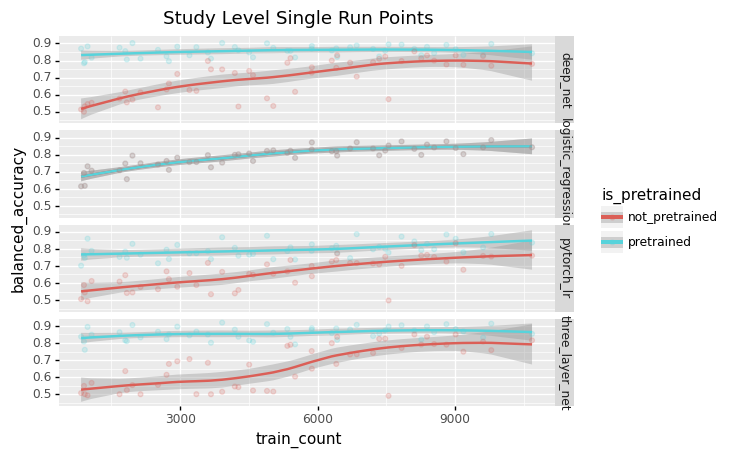

<ggplot: (8759142789401)>

In [46]:
plot = ggplot(single_run_df, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Study Level Single Run Points')
plot += facet_grid('supervised ~ .')
plot

## Tissue Signal Removed

### Sample level

In [47]:
in_files = glob.glob('../../results/sample-split-signal-removed.*.tsv')
print(in_files[:5])

['../../results/sample-split-signal-removed.logistic_regression_2.tsv', '../../results/sample-split-signal-removed.pytorch_lr_0.tsv', '../../results/sample-split-signal-removed.deep_net_1.tsv', '../../results/sample-split-signal-removed.logistic_regression_1.tsv', '../../results/sample-split-signal-removed.logistic_regression_0.tsv']


In [48]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

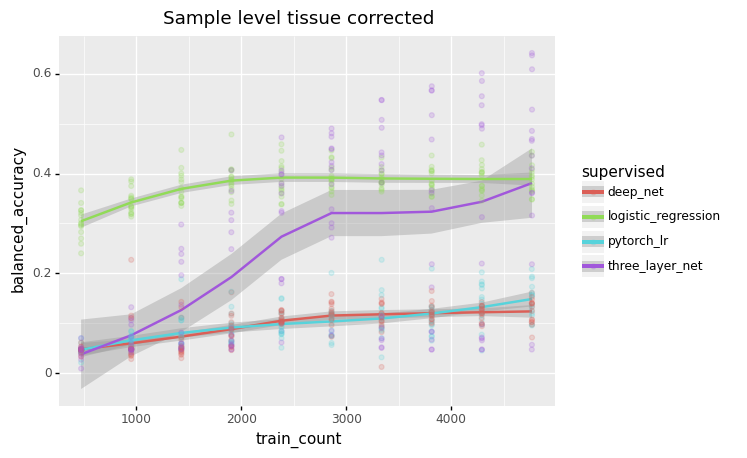

<ggplot: (8759142492301)>

In [49]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='supervised'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sample level tissue corrected')
plot

### Study level

In [50]:
in_files = glob.glob('../../results/study-split-signal-removed.*.tsv')
print(in_files[:5])

['../../results/study-split-signal-removed.pytorch_lr_1.tsv', '../../results/study-split-signal-removed.deep_net_1.tsv', '../../results/study-split-signal-removed.pytorch_lr_0.tsv', '../../results/study-split-signal-removed.deep_net_0.tsv', '../../results/study-split-signal-removed.logistic_regression_0.tsv']


In [51]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

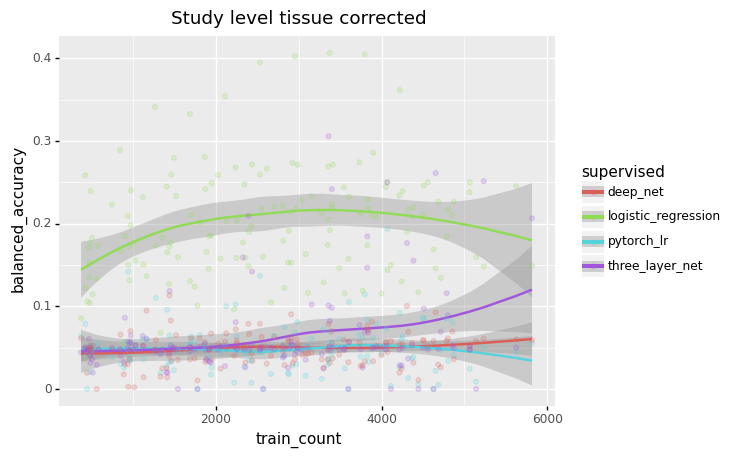

<ggplot: (8759141867185)>

In [52]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='supervised'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Study level tissue corrected')
plot

## Study Signal Removed

### Sample level

In [53]:
in_files = glob.glob('../../results/sample-split-study-corrected.*.tsv')
print(in_files[:5])

['../../results/sample-split-study-corrected.pytorch_supervised_0.tsv', '../../results/sample-split-study-corrected.pytorch_lr_0.tsv', '../../results/sample-split-study-corrected.pytorch_supervised_2.tsv', '../../results/sample-split-study-corrected.deep_net_0.tsv', '../../results/sample-split-study-corrected.pytorch_lr_1.tsv']


In [54]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

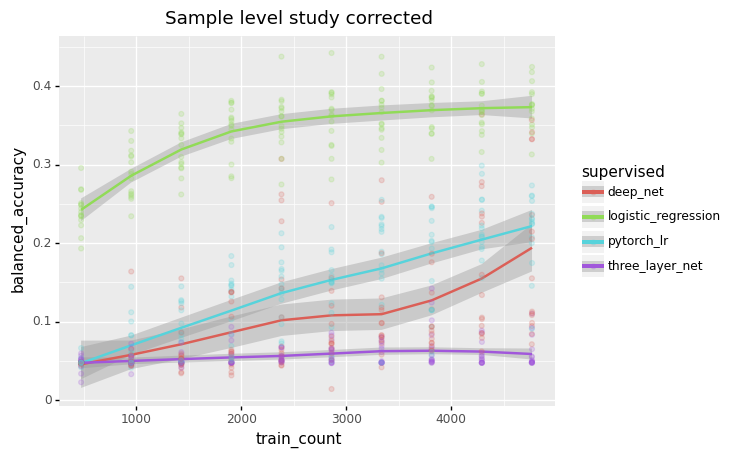

<ggplot: (8759141941209)>

In [55]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='supervised'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sample level study corrected')
plot

### Study level

In [56]:
in_files = glob.glob('../../results/study-split-study-corrected.*.tsv')
print(in_files[:5])

['../../results/study-split-study-corrected.logistic_regression_1.tsv', '../../results/study-split-study-corrected.logistic_regression_0.tsv', '../../results/study-split-study-corrected.pytorch_supervised_2.tsv', '../../results/study-split-study-corrected.pytorch_lr_2.tsv', '../../results/study-split-study-corrected.pytorch_lr_0.tsv']


In [57]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

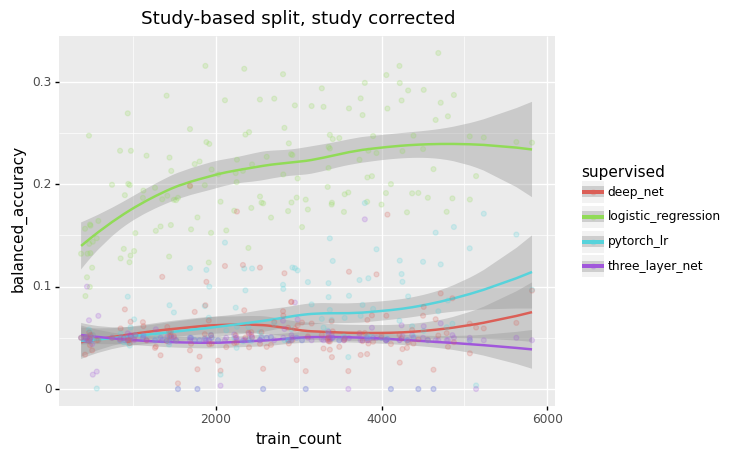

<ggplot: (8759142288845)>

In [58]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='supervised'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Study-based split, study corrected')
plot